# MIX number calculation

This script performs a simple calculation of the MIX number for a 1-D storage in order to provide a deeper understaning on how assess stratification of a storage using the MIX number.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from temperature_profile import temp_profile
from matplotlib import animation
from matplotlib.animation import FuncAnimation

Enter the simulation settings.

In [2]:
# Water proprties
density_water = 980 # in kg/m3
specific_heat_water = 4200  # in J/(kg K)

# Simulation properties
simulated_case = '' # Set the case that will be simulated, e.g. "fully_mixed", "fully_stratified". Otherwise, it simulates storage operation with mixing based on mixing_nodes.
heat_loss_coeff = 6 # in W/(m^2 K). This number gives a 90% storage efficiency for the selected settings. Set to 0 for no heat loss.

N = 60 # number of tank nodes
mix_nodes = int(N/10) # number of nodes close to the inlet that are mixed for imitating inlet jet mixing. Has to be integer!!!

T_hot = 90 # charge temperature
T_cold = 45 # discharge temperature
T_threshold = 10 # temperature threshold for considering the tank full/empty. E.g. if it is 10 degC then the tank is fully when the bottom is at 80 degC
T_amb = 10 # ambient temperature for calculatio of heat losses

th_cond_coeff = 2.5 # effective vertical thermal conductivity coefficient in W/(m K)
simulation_period = 1500 # This period is overwritten based on the maximum number of cycles set below. Has to be a large number!!
max_storage_cycles = 2 # stops the simulation after a number of charge-discharge cyles

plot = False # Plots the temperature profile in the tank

# Storage properties
storage_height = 1 # the height of storage in m
storage_volume = 1 # the volume of storage in m^3
volume_per_layer = 1/N # assuming that the storage is 1-D
mass_per_layer = density_water * volume_per_layer # mass per layer
storage_mass = density_water * storage_volume # total storage mass

Create dataframe containing the temperature profiles for each time step. Rows are the simulation time steps and columns are the layers of the storage starting from the top (0) to the bottom (N).

The "df_ancil" is a dataframe that contains the calculated heat loss entropy, storage entropy, heat loss (energy), energy rate, energy content, and charge status.

In [3]:
df, df_ancil = temp_profile(simulated_case, N, mix_nodes, T_hot, T_cold, T_threshold, th_cond_coeff, simulation_period,
                             heat_loss_coeff, plot=plot, max_storage_cycles=max_storage_cycles, T_amb=T_amb)

The MIX number evauates stratification based on the temperature profile in the storage and the energy content of the storage and it is determined using the moment of energy $(M_{E})$. This number is defined as the difference in moment of energy between a perfectly stratified storage and an actual storage, to the difference in moment of energy between a perfeclty stratified storage and a fully mixed one. It is expressed by the following euqation:

$$MIX = \frac{M_{E}^{stratified} - M_{E}^{actual}}{M_{E}^{stratified} - M_{E}^{fully-mixed}} \tag{1}$$

MIX number is a dimensionless number, where $0$ represents a perfeclty stratified tank, while $1$ indicates a fully-mixed tank. For the calculations, the sotrage is divided in to layers based on the number of temperature measurements.The moment of energy $(M_{E})$, is calculated by suming up all the storage layers, using the following formula:

$$M_{E} = \sum_{n=1}^{N} \rho_{i} \cdot V_{i} \cdot C_{p,i} \cdot (T_{i} - T_{ref}) \cdot z_{i} \tag{2}$$

Where $n$ is a storage layer and $N$ is the total number of layers in the storage. For each layer, $\rho_{i}$ is the density of water, $V_{i}$ is the volume of water, $T_{i}$ is the water temperatrue, $T_{ref}$ is the selected reference temperature (aka the temperature at which the storage is considered empty), $C_{p,i}$ is the specific heat of water and $z_{i}$ is the distance from the center of the layer to the bottom of the storage.



First the energy content of the investigated storage is calculated.

In [4]:
T_ref = T_cold # reference temperature for calculating energy

Q_storage = (density_water * volume_per_layer * specific_heat_water * (df - T_ref)).sum(axis='columns') # energy content of storage

The moment of energy is calculated for a fully mixed storage. The temperature of the fully mixed storage is the average temperature of the actual storage for each timestep. The volume of the mixed storage ($V_{min}$) is essentially equal with the volume of the actual storage. The distance from the middle of the volume to the bottom of the storage is in this case, due to the simplified geoemtry, equal to half the height of the actual storage.

In [5]:
T_avg = (df*mass_per_layer/storage_mass).sum(axis=1) # weighted average temperature of mixed storage

V_mix = Q_storage/(density_water * specific_heat_water * (T_avg - T_ref)) # volume of mixed storage using the energy content of the actual storage

dist_mix = storage_height/2 # distance from the bottom of the storage to the middle of the V_mix (=storage_height)

M_mix = density_water * specific_heat_water * V_mix * (T_avg - T_ref) * dist_mix # moment of energy for fully mixed storage

The perfeclty stratified storage is defined as a strorage that has the same energy content with the actual storage but has always the highest possible temperature ($T_{hot}$) at the top. The volume of the storage that is not used by this temprature is assumed to have the lowest possible temperature ($T_{ref} = T_{cold}$) and thus no energy content.

In [6]:
V_hot = Q_storage/(density_water * specific_heat_water * (T_hot - T_ref)) # volume of hot water in the stratified storage using energy content of actual storage

dist_hot = storage_height - (V_hot/storage_volume)/2 # distance from the bottom of the storage

M_strat = density_water * V_hot * specific_heat_water * (T_hot - T_ref) * dist_hot # Moment of energy for stratified tank

Calculation of the moment of energy for the actual storage.

In [7]:
dist = np.arange(1/N/2, 1, 1/N)[::-1] # Make an array with the distances of each layer from the bottom of the storage

M_exp = density_water * volume_per_layer* dist * specific_heat_water * (df - T_ref) # Moment of energy for the actual storage

Calculation of the MIX number for the storage using equation $(1)$.

In [8]:
MIX = (M_strat - M_exp.sum(axis=1)) / (M_strat - M_mix)

Plot of the MIX number along with the energy content of the storage.

(0.0, 1.0)

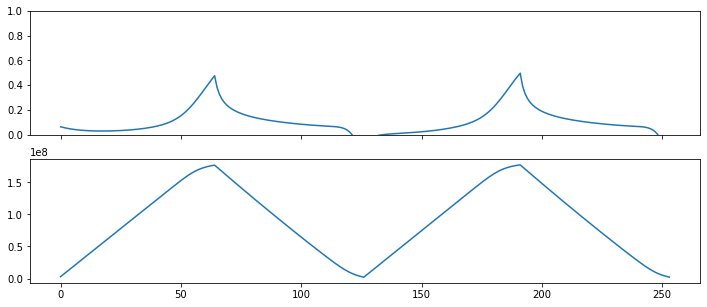

In [9]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12,5))
MIX.plot(ax=axes[0])
Q_storage.plot(ax=axes[1])
axes[0].set_ylim(0,1)

## Comments on MIX number

The MIX number is strongly affected by the selection of the arbitrary $T_{ref}$. It is suggested that the selected reference temperature should be equal to the lowest temperatrue of the storage (aka when the storage is considered empty). However, for heat storages with solar thermal collectors and heat pump (e.g. Dronninglund, Marstal), it is not straightforward to select the reference temperatue since the storage has two cold levels.

The MIX number is affected by the energy content of the storage. At high (fully charged) and low (fully discharged) energy contents large spikes can be noticed in the MIX number, because a fully charged and discharged storage is considered as not being stratified.

Last, the MIX number is instantaneous indication of the conditions in the storage and cannot be averaged for assessing the performance of the storage for a longer period.

It is not possible to use the "fully_mixed" and "fully_stratified" simulated_scenarios for the calculation of the MIX number in combination with the "actual" case. The reason is that the charge and discharge in these cases happens at a different time so mathmatical operations cannot be done between them (e.g. to subtract and divide them). This is why the reference scenarios have to be calculated based on the experimental storage, so that thtey have the same time for the charge an discharge.